In [10]:
import pandas as pd
import numpy as np
from pmdarima import auto_arima #to figure out the best orders for p,d,q using gridsearch
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv('time_series/Data/co2_mm_mlo.csv')
df['date'] = pd.to_datetime(df[['year','month']].assign(day=1))
df.set_index('date', inplace = True)
df.index.freq = 'MS'

In [11]:
df.head()

,year,month,decimal_date,average,interpolated
date,,,,,
1958-03-01,1958,3,1958.208,315.71,315.71
1958-04-01,1958,4,1958.292,317.45,317.45
1958-05-01,1958,5,1958.375,317.50,317.50
1958-06-01,1958,6,1958.458,NaN,317.10
1958-07-01,1958,7,1958.542,315.86,315.86


<AxesSubplot:xlabel='date'>

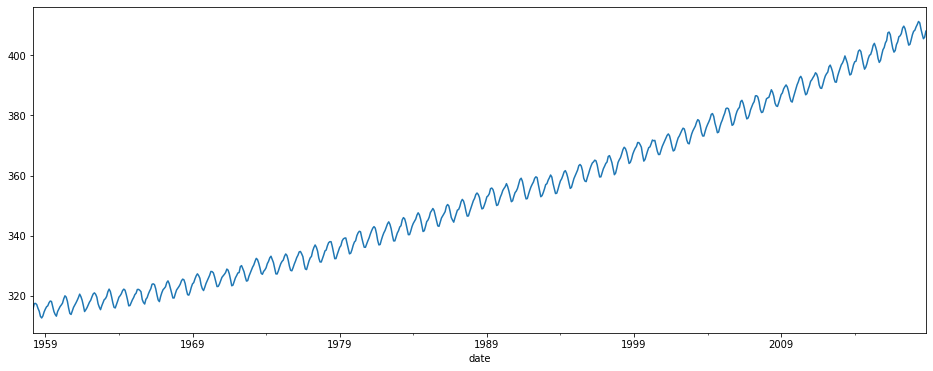

In [12]:
df['interpolated'].plot(figsize=(16,6))

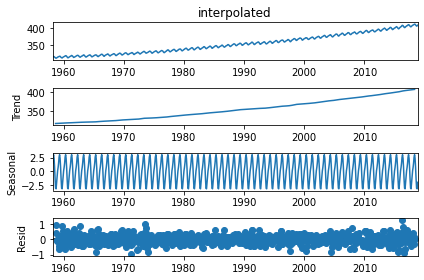

In [13]:
result = seasonal_decompose(df['interpolated'], model='add')
result.plot();

12

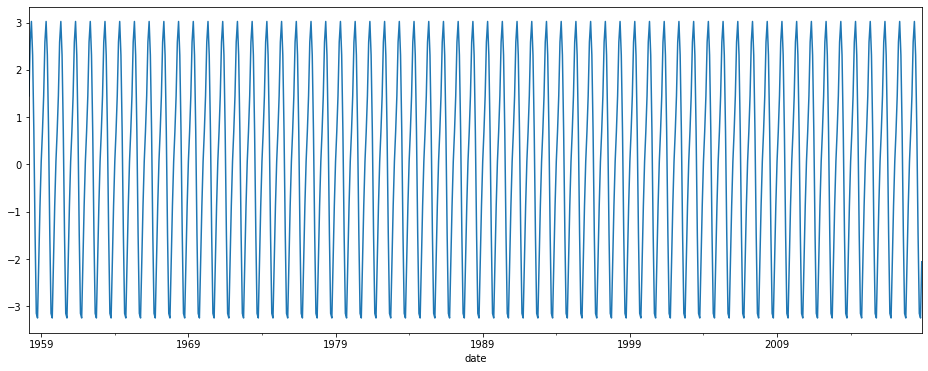

In [22]:
result.seasonal.plot(figsize=(16,6)) #In case you don't know seasonal value, magnify the seasonal component and see m value
result.seasonal.nunique()

In [23]:
auto_arima(df['interpolated'], seasonal=True, m=12).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  729
Model:             SARIMAX(2, 1, 1)x(1, 0, 1, 12)   Log Likelihood                -206.264
Date:                            Wed, 08 Feb 2023   AIC                            424.528
Time:                                    11:55:57   BIC                            452.070
Sample:                                03-01-1958   HQIC                           435.155
                                     - 11-01-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3522      0.063      5.618      0.000       0.229       0.475
ar.L2          0.0891      0.032      2.768      0.006       0.026       0.152
ma.L1         -0.7086      0.061    -11.622      0.000      -0.828      -0.589
ar.S.L12       0.9996      0.000   2746.600      0.000       0.999       1.000
ma.S.L12      -0.8650      0.021    -40.286      0.000      -0.907      -0.823
sigma2         0.0958      0.005     20.292      0.000       0.087       0.105
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):                 4.40
Prob(Q):                              0.82   Prob(JB):                         0.11
Heteroskedasticity (H):               1.13   Skew:                            -0.00
Prob(H) (two-sided):                  0.35   Kurtosis:                         3.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [24]:
len(df)

729

In [25]:
train = df.iloc[:717]
test = df.iloc[717:]
model = SARIMAX(train['interpolated'], order=(2,1,1), seasonal_order=(1,0,1,12))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                       interpolated   No. Observations:                  717
Model:             SARIMAX(2, 1, 1)x(1, 0, 1, 12)   Log Likelihood                -201.896
Date:                            Wed, 08 Feb 2023   AIC                            415.791
Time:                                    12:08:01   BIC                            443.234
Sample:                                03-01-1958   HQIC                           426.388
                                     - 11-01-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3317      0.076      4.375      0.000       0.183       0.480
ar.L2          0.0768      0.036      2.151      0.031       0.007       0.147
ma.L1         -0.6871      0.071     -9.735      0.000      -0.825      -0.549
ar.S.L12       0.9996      0.000   2946.181      0.000       0.999       1.000
ma.S.L12      -0.8663      0.023    -38.326      0.000      -0.911      -0.822
sigma2         0.0952      0.005     20.612      0.000       0.086       0.104
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):                 4.69
Prob(Q):                              0.83   Prob(JB):                         0.10
Heteroskedasticity (H):               1.14   Skew:                             0.01
Prob(H) (two-sided):                  0.31   Kurtosis:                         3.40
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [26]:
start = len(train)
end = len(df) - 1
predictions = results.predict(start=start, end=end, typ='levels').rename('SARIMA Predictions')
#typ='levels' for original variables without differncing
predictions

2017-12-01    406.599074
2018-01-01    407.814524
2018-02-01    408.568786
2018-03-01    409.477672
2018-04-01    411.035944
2018-05-01    411.639905
2018-06-01    410.860701
2018-07-01    409.171164
2018-08-01    407.071170
2018-09-01    405.621084
2018-10-01    405.891340
2018-11-01    407.424694
Freq: MS, Name: SARIMA Predictions, dtype: float64

<AxesSubplot:xlabel='date'>

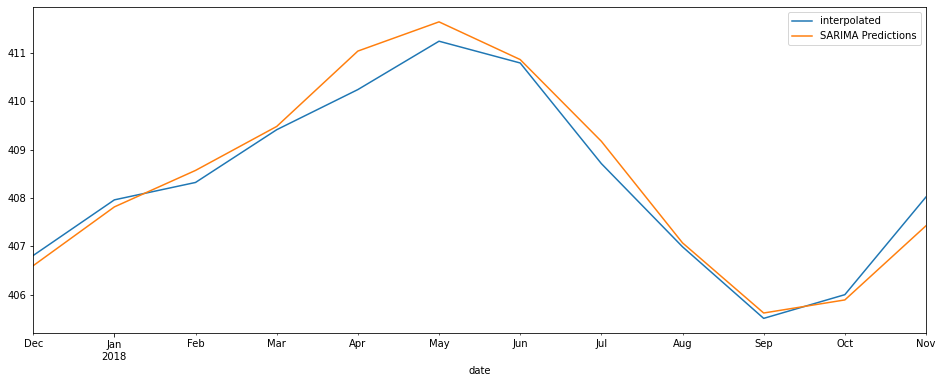

In [27]:
test['interpolated'].plot(figsize=(16,6), legend=True)
predictions.plot(legend=True)

In [29]:
from statsmodels.tools.eval_measures import rmse
error = rmse(test['interpolated'], predictions)
error #less differnce between the test mean and rsme

0.35688158261680886

In [30]:
test['interpolated'].mean()

408.3333333333333

In [31]:
#Forecast into the future for 1 year
model = SARIMAX(df['interpolated'],  order=(2,1,1), seasonal_order=(1,0,1,12))
results = model.fit()
fcast = results.predict(start=len(df),end=len(df)+11,typ='levels').rename('SARIMAX Forecast')

<AxesSubplot:xlabel='date'>

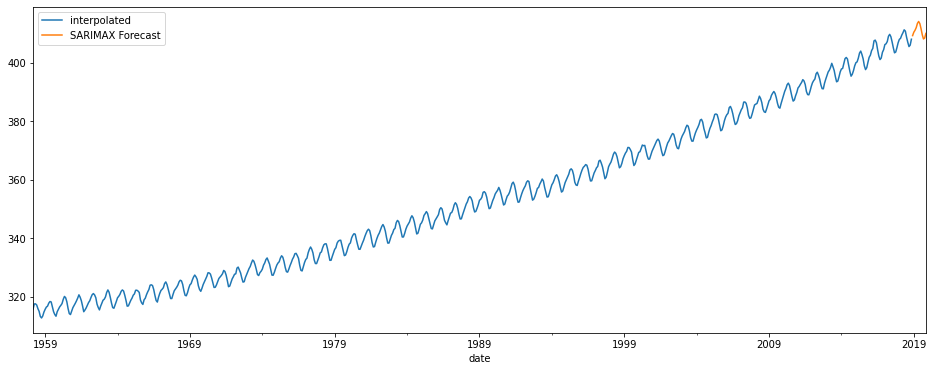

In [32]:
df['interpolated'].plot(figsize=(16,6),legend=True)
fcast.plot(legend=True)

## SARIMA with exogenous variables

In [108]:
df2 = pd.read_csv('time_series/Data/RestaurantVisitors.csv',index_col='date',parse_dates=True)
df2.index.freq = 'D'
df2.head() #holiday is exogenous variable

,weekday,holiday,holiday_name,rest1,rest2,rest3,rest4,total
date,,,,,,,,
2016-01-01,Friday,1,New Year's Day,65.0,25.0,67.0,139.0,296.0
2016-01-02,Saturday,0,na,24.0,39.0,43.0,85.0,191.0
2016-01-03,Sunday,0,na,24.0,31.0,66.0,81.0,202.0
2016-01-04,Monday,0,na,23.0,18.0,32.0,32.0,105.0
2016-01-05,Tuesday,0,na,2.0,15.0,38.0,43.0,98.0


In [109]:
df3 = df2.dropna()
df3[['rest1','rest2','rest3','rest4','total']] = df3[['rest1','rest2','rest3','rest4','total']].astype(int)
df3.head()

,weekday,holiday,holiday_name,rest1,rest2,rest3,rest4,total
date,,,,,,,,
2016-01-01,Friday,1,New Year's Day,65,25,67,139,296
2016-01-02,Saturday,0,na,24,39,43,85,191
2016-01-03,Sunday,0,na,24,31,66,81,202
2016-01-04,Monday,0,na,23,18,32,32,105
2016-01-05,Tuesday,0,na,2,15,38,43,98


<AxesSubplot:xlabel='date'>

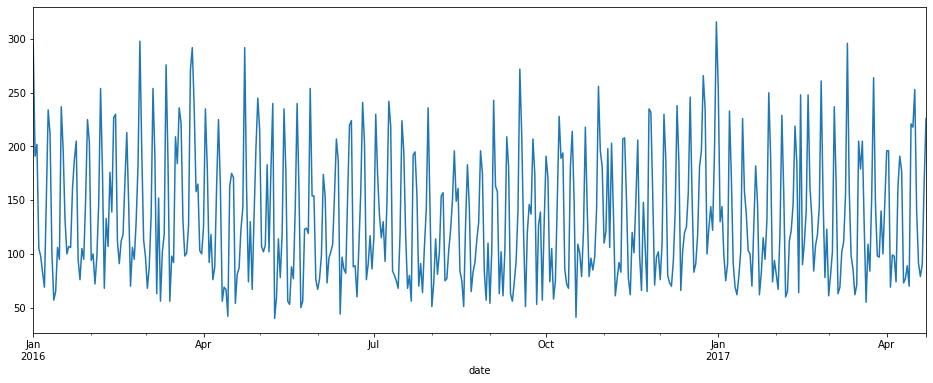

In [110]:
df3['total'].plot(figsize=(16,6))

In [111]:
df3[df3['holiday']==1].index

DatetimeIndex(['2016-01-01', '2016-01-18', '2016-02-02', '2016-02-14',
               '2016-02-15', '2016-03-17', '2016-03-25', '2016-03-27',
               '2016-03-28', '2016-05-05', '2016-05-08', '2016-05-30',
               '2016-06-19', '2016-07-04', '2016-09-05', '2016-10-10',
               '2016-10-31', '2016-11-11', '2016-11-24', '2016-11-25',
               '2016-12-24', '2016-12-25', '2016-12-31', '2017-01-01',
               '2017-01-16', '2017-02-02', '2017-02-14', '2017-02-20',
               '2017-03-17', '2017-04-14', '2017-04-16', '2017-04-17'],
              dtype='datetime64[ns]', name='date', freq=None)

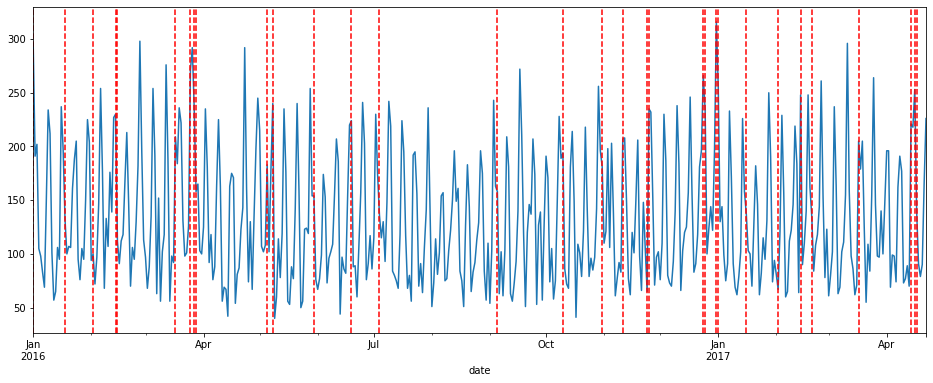

In [112]:
ax = df3['total'].plot(figsize=(16,6))
for date in df3[df3['holiday']==1].index:
    ax.axvline(x=date, color='red', linestyle='--')

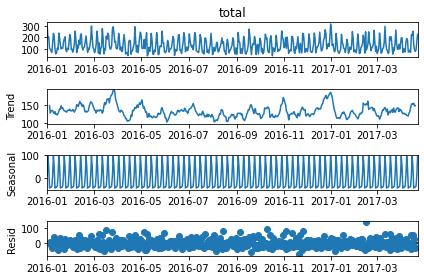

In [113]:
result = seasonal_decompose(df3['total'], model='add')
result.plot();

7

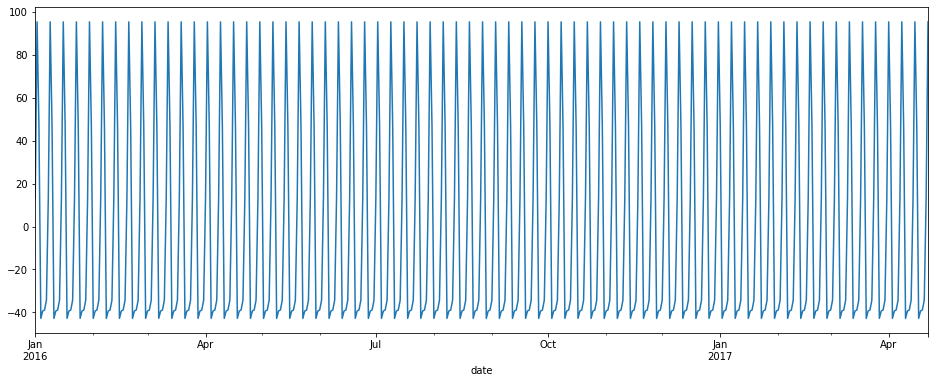

In [114]:
result.seasonal.plot(figsize=(16,6)) #In case you don't know seasonal value, magnify the seasonal component and see m value
result.seasonal.nunique()

In [115]:
len(df3) #take 1 month() for testing

478

In [116]:
stepwise_fit = auto_arima(df3['total'], start_p=0, start_q=0, seasonal=True, max_p=2,max_q=2,m=7,
                        trace=True) 
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[7] intercept   : AIC=4766.843, Time=0.78 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=5269.484, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=4916.749, Time=0.52 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=5049.644, Time=0.35 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=6126.084, Time=0.01 sec
 ARIMA(0,0,0)(0,0,1)[7] intercept   : AIC=5093.130, Time=0.15 sec
 ARIMA(0,0,0)(1,0,0)[7] intercept   : AIC=4926.360, Time=0.34 sec
 ARIMA(0,0,0)(2,0,1)[7] intercept   : AIC=5424.740, Time=1.47 sec
 ARIMA(0,0,0)(1,0,2)[7] intercept   : AIC=4978.420, Time=1.35 sec
 ARIMA(0,0,0)(0,0,2)[7] intercept   : AIC=5010.582, Time=0.55 sec
 ARIMA(0,0,0)(2,0,0)[7] intercept   : AIC=4859.737, Time=1.67 sec
 ARIMA(0,0,0)(2,0,2)[7] intercept   : AIC=inf, Time=1.80 sec
 ARIMA(1,0,0)(1,0,1)[7] intercept   : AIC=4792.309, Time=0.87 sec
 ARIMA(0,0,1)(1,0,1)[7] intercept   : AIC=inf, Time=1.01 sec
 ARIMA(1,0,1)(1,0,1)[7] intercept   : AIC=i

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 SARIMAX Results                                 
=================================================================================
Dep. Variable:                         y   No. Observations:                  478
Model:             SARIMAX(1, 0, [1], 7)   Log Likelihood               -2379.422
Date:                   Wed, 08 Feb 2023   AIC                           4766.843
Time:                           18:15:35   BIC                           4783.521
Sample:                       01-01-2016   HQIC                          4773.400
                            - 04-22-2017                                         
Covariance Type:                     opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      3.4151      1.404      2.433      0.015       0.663       6.167
ar.S.L7        0.9723      0.011     88.860      0.000       0.951       0.994
ma.S.L7       -0.7874      0.047    -16.821      0.000      -0.879      -0.696
sigma2      1216.0815     71.884     16.917      0.000    1075.192    1356.971
===================================================================================
Ljung-Box (L1) (Q):                  15.43   Jarque-Bera (JB):                72.18
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.85   Skew:                             0.78
Prob(H) (two-sided):                  0.31   Kurtosis:                         4.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [117]:
auto_arima(df3['total'],seasonal=True,m=7).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 SARIMAX Results                                 
=================================================================================
Dep. Variable:                         y   No. Observations:                  478
Model:             SARIMAX(1, 0, [1], 7)   Log Likelihood               -2379.422
Date:                   Wed, 08 Feb 2023   AIC                           4766.843
Time:                           18:15:58   BIC                           4783.521
Sample:                       01-01-2016   HQIC                          4773.400
                            - 04-22-2017                                         
Covariance Type:                     opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      3.4151      1.404      2.433      0.015       0.663       6.167
ar.S.L7        0.9723      0.011     88.860      0.000       0.951       0.994
ma.S.L7       -0.7874      0.047    -16.821      0.000      -0.879      -0.696
sigma2      1216.0815     71.884     16.917      0.000    1075.192    1356.971
===================================================================================
Ljung-Box (L1) (Q):                  15.43   Jarque-Bera (JB):                72.18
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.85   Skew:                             0.78
Prob(H) (two-sided):                  0.31   Kurtosis:                         4.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [118]:
train = df3.iloc[:436]
test = df3.iloc[436:]
model = SARIMAX(train['total'], order=(0,0,0), seasonal_order=(1,0,1,7), enforce_invertibility=False)
results = model.fit()
#Force invertibility means the most rescent obserrvations  have highre weights than observations from more distant past
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 SARIMAX Results                                 
=================================================================================
Dep. Variable:                     total   No. Observations:                  436
Model:             SARIMAX(1, 0, [1], 7)   Log Likelihood               -2165.369
Date:                   Wed, 08 Feb 2023   AIC                           4336.738
Time:                           18:15:59   BIC                           4348.970
Sample:                       01-01-2016   HQIC                          4341.565
                            - 03-11-2017                                         
Covariance Type:                     opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L7        0.9999   9.56e-05   1.05e+04      0.000       1.000       1.000
ma.S.L7       -0.9384      0.024    -39.211      0.000      -0.985      -0.891
sigma2      1111.7936     58.740     18.927      0.000     996.664    1226.923
===================================================================================
Ljung-Box (L1) (Q):                  15.40   Jarque-Bera (JB):                83.57
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.96   Skew:                             0.72
Prob(H) (two-sided):                  0.81   Kurtosis:                         4.59
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [119]:
start = len(train)
end = len(df3) - 1
predictions = results.predict(start,end).rename('SARIMA Predictions')
#typ='levels' for original variables without differncing
predictions

2017-03-12    172.108630
2017-03-13     87.862852
2017-03-14     99.903195
2017-03-15     96.839533
2017-03-16     98.639273
2017-03-17    140.731443
2017-03-18    235.743438
2017-03-19    172.091271
2017-03-20     87.853989
2017-03-21     99.893118
2017-03-22     96.829765
2017-03-23     98.629324
2017-03-24    140.717249
2017-03-25    235.719660
2017-03-26    172.073913
2017-03-27     87.845128
2017-03-28     99.883043
2017-03-29     96.819999
2017-03-30     98.619376
2017-03-31    140.703056
2017-04-01    235.695885
2017-04-02    172.056557
2017-04-03     87.836268
2017-04-04     99.872968
2017-04-05     96.810233
2017-04-06     98.609429
2017-04-07    140.688864
2017-04-08    235.672112
2017-04-09    172.039203
2017-04-10     87.827409
2017-04-11     99.862895
2017-04-12     96.800469
2017-04-13     98.599483
2017-04-14    140.674674
2017-04-15    235.648341
2017-04-16    172.021851
2017-04-17     87.818550
2017-04-18     99.852822
2017-04-19     96.790705
2017-04-20     98.589538


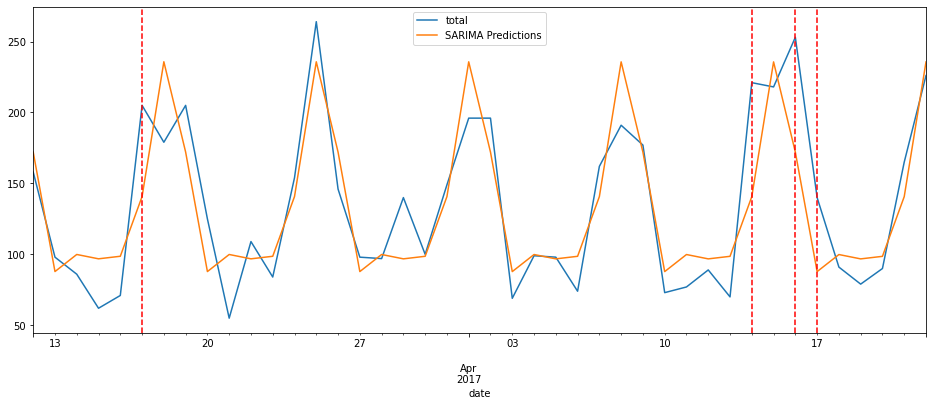

In [120]:
ax = test['total'].plot(figsize=(16,6), legend=True)
predictions.plot(legend=True)

for date in test[test['holiday']==1].index:
    ax.axvline(x=date, color='red', linestyle='--') #our model does not pick ups the peaks where holidays exist so we have
#to consider exogenous variables later

In [121]:
from statsmodels.tools.eval_measures import rmse
error = rmse(test['total'], predictions)
error #less differnce between the test mean and rsme

31.911801666501823

In [122]:
test['total'].mean()

134.26190476190476

## SARIMA with exogenous varaibales(SARIMAX)

In [123]:
stepwise_fit = auto_arima(df3['total'],exogenous=df3['holiday'], start_p=0, start_q=0, seasonal=True, max_p=4,max_q=4,m=7,
                        trace=True) 
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[7] intercept   : AIC=4766.843, Time=0.79 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=5269.484, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=4916.749, Time=0.48 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=5049.644, Time=0.33 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=6126.084, Time=0.01 sec
 ARIMA(0,0,0)(0,0,1)[7] intercept   : AIC=5093.130, Time=0.16 sec
 ARIMA(0,0,0)(1,0,0)[7] intercept   : AIC=4926.360, Time=0.34 sec
 ARIMA(0,0,0)(2,0,1)[7] intercept   : AIC=5424.740, Time=1.52 sec
 ARIMA(0,0,0)(1,0,2)[7] intercept   : AIC=4978.420, Time=1.28 sec
 ARIMA(0,0,0)(0,0,2)[7] intercept   : AIC=5010.582, Time=0.55 sec
 ARIMA(0,0,0)(2,0,0)[7] intercept   : AIC=4859.737, Time=1.61 sec
 ARIMA(0,0,0)(2,0,2)[7] intercept   : AIC=inf, Time=1.78 sec
 ARIMA(1,0,0)(1,0,1)[7] intercept   : AIC=4792.309, Time=0.85 sec
 ARIMA(0,0,1)(1,0,1)[7] intercept   : AIC=inf, Time=1.04 sec
 ARIMA(1,0,1)(1,0,1)[7] intercept   : AIC=i

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 SARIMAX Results                                 
=================================================================================
Dep. Variable:                         y   No. Observations:                  478
Model:             SARIMAX(1, 0, [1], 7)   Log Likelihood               -2379.422
Date:                   Wed, 08 Feb 2023   AIC                           4766.843
Time:                           18:16:31   BIC                           4783.521
Sample:                       01-01-2016   HQIC                          4773.400
                            - 04-22-2017                                         
Covariance Type:                     opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      3.4151      1.404      2.433      0.015       0.663       6.167
ar.S.L7        0.9723      0.011     88.860      0.000       0.951       0.994
ma.S.L7       -0.7874      0.047    -16.821      0.000      -0.879      -0.696
sigma2      1216.0815     71.884     16.917      0.000    1075.192    1356.971
===================================================================================
Ljung-Box (L1) (Q):                  15.43   Jarque-Bera (JB):                72.18
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.85   Skew:                             0.78
Prob(H) (two-sided):                  0.31   Kurtosis:                         4.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [124]:
auto_arima(df3['total'],seasonal=True,m=7, exogenous=df3[['holiday']]).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 SARIMAX Results                                 
=================================================================================
Dep. Variable:                         y   No. Observations:                  478
Model:             SARIMAX(1, 0, [1], 7)   Log Likelihood               -2379.422
Date:                   Wed, 08 Feb 2023   AIC                           4766.843
Time:                           18:17:39   BIC                           4783.521
Sample:                       01-01-2016   HQIC                          4773.400
                            - 04-22-2017                                         
Covariance Type:                     opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      3.4151      1.404      2.433      0.015       0.663       6.167
ar.S.L7        0.9723      0.011     88.860      0.000       0.951       0.994
ma.S.L7       -0.7874      0.047    -16.821      0.000      -0.879      -0.696
sigma2      1216.0815     71.884     16.917      0.000    1075.192    1356.971
===================================================================================
Ljung-Box (L1) (Q):                  15.43   Jarque-Bera (JB):                72.18
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.85   Skew:                             0.78
Prob(H) (two-sided):                  0.31   Kurtosis:                         4.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [125]:
model = SARIMAX(train['total'],exog=train[['holiday']], order=(0,0,0), seasonal_order=(1,0,1,7), enforce_invertibility=False)
results = model.fit()
#Force invertibility means the most rescent obserrvations  have highre weights than observations from more distant past
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 SARIMAX Results                                 
=================================================================================
Dep. Variable:                     total   No. Observations:                  436
Model:             SARIMAX(1, 0, [1], 7)   Log Likelihood               -2098.580
Date:                   Wed, 08 Feb 2023   AIC                           4205.159
Time:                           18:18:39   BIC                           4221.470
Sample:                       01-01-2016   HQIC                          4211.596
                            - 03-11-2017                                         
Covariance Type:                     opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
holiday       70.0684      3.972     17.639      0.000      62.283      77.854
ar.S.L7        1.0000   4.72e-05   2.12e+04      0.000       1.000       1.000
ma.S.L7       -1.0463      0.024    -42.751      0.000      -1.094      -0.998
sigma2       739.3351     49.502     14.935      0.000     642.313     836.358
===================================================================================
Ljung-Box (L1) (Q):                  15.36   Jarque-Bera (JB):                21.14
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.01   Skew:                             0.23
Prob(H) (two-sided):                  0.96   Kurtosis:                         3.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [82]:
start = len(train)
end = len(df3) - 1
predictions = results.predict(start,end,exog=test[['holiday']]).rename('SARIMAX Predictions')
#typ='levels' for original variables without differncing
predictions

2017-03-12    167.882819
2017-03-13     77.322190
2017-03-14     94.903293
2017-03-15     96.341911
2017-03-16     93.780856
2017-03-17    208.464328
2017-03-18    229.476453
2017-03-19    167.876897
2017-03-20     77.319463
2017-03-21     94.899945
2017-03-22     96.338512
2017-03-23     93.777548
2017-03-24    138.391017
2017-03-25    229.468358
2017-03-26    167.870975
2017-03-27     77.316735
2017-03-28     94.896598
2017-03-29     96.335114
2017-03-30     93.774240
2017-03-31    138.386135
2017-04-01    229.460264
2017-04-02    167.865053
2017-04-03     77.314008
2017-04-04     94.893250
2017-04-05     96.331715
2017-04-06     93.770932
2017-04-07    138.381254
2017-04-08    229.452169
2017-04-09    167.859132
2017-04-10     77.311280
2017-04-11     94.889903
2017-04-12     96.328317
2017-04-13     93.767624
2017-04-14    208.444801
2017-04-15    229.444075
2017-04-16    237.921639
2017-04-17    147.376982
2017-04-18     94.886555
2017-04-19     96.324919
2017-04-20     93.764316


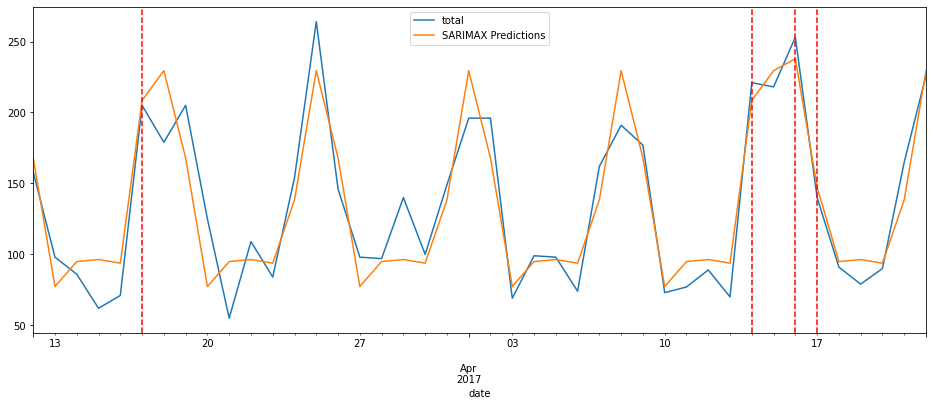

In [83]:
ax = test['total'].plot(figsize=(16,6), legend=True)
predictions.plot(legend=True)

for date in test[test['holiday']==1].index:
    ax.axvline(x=date, color='red', linestyle='--') #Now able to hit the points where holidays occured

In [84]:
error = rmse(test['total'], predictions)
error #less differnce between the test mean and rsme

22.811647349939218

In [85]:
test['total'].mean()

134.26190476190476

In [91]:
df2.tail() #We know the exogenous variable value for the future period

,weekday,holiday,holiday_name,rest1,rest2,rest3,rest4,total
date,,,,,,,,
2017-05-27,Saturday,0,na,NaN,NaN,NaN,NaN,NaN
2017-05-28,Sunday,0,na,NaN,NaN,NaN,NaN,NaN
2017-05-29,Monday,1,Memorial Day,NaN,NaN,NaN,NaN,NaN
2017-05-30,Tuesday,0,na,NaN,NaN,NaN,NaN,NaN
2017-05-31,Wednesday,0,na,NaN,NaN,NaN,NaN,NaN


In [127]:
#Forecast into the future for 1 year
model = SARIMAX(df3['total'],exog=df3[['holiday']],order=(0,0,0), seasonal_order=(1,0,1,7), enforce_invertibility=False)
results = model.fit()
exog_forecast = df2[478:][['holiday']]
fcast = results.predict(start=len(df3),end=len(df3)+38,exog=exog_forecast).rename('Final SARIMAX Forecast')

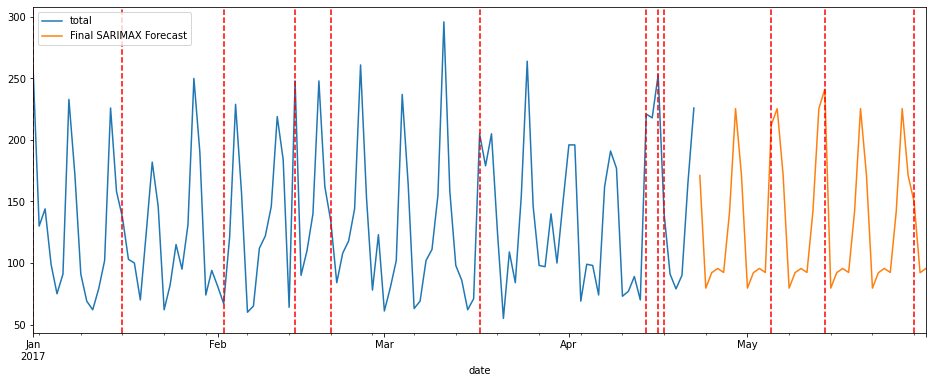

In [131]:
ax = df3['total'].loc['2017-01-01':].plot(figsize=(16,6),legend=True)
fcast.plot(legend=True)

for date in df2[df2['holiday']==1].index:
    ax.axvline(x=date, color='red', linestyle='--') #Now able to hit the points where holidays occured